# NLP Disaster Tweets Mini-Project

##  Problem Definition
This is a project to use Kaggle's Natural Language Processing with Disaster Tweets competition to do exploratory data analysis (EDA), model building and training, and comparison with deep learning. 
In this case, the technique we will be exploring is **LSTM**. 

Information about the competition can be found at https://www.kaggle.com/competitions/nlp-getting-started/overview.
The goal will be to create a model that can predict whether tweets are about real disasters or not.

### Dataset Information
The data is from the Kaggle competition. There is a dataset of 10,000 tweets that were hand classified. The train and test set have the text of a tweet, a keyword from that tweet, and the location it was sent from. If the tweet is about a real distaster, it should predict 1, otherwise 0. 

Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
# nltk.download('punkt')
# nltk.download('punkt_tab')
from gensim.models import Word2Vec
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import re
import string
import os
from collections import defaultdict
from collections import Counter
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [77]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
print(train.shape)
print(test.shape)
print(train.columns)

(7613, 5)
(3263, 4)
Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
I will view the data and determine if it needs cleaning or other handling. I will also visualize the data to form a plan of analysis.

In [78]:
print(train.head())
print(train.info())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


The datatypes look good. Let's check for duplicates and nans.

In [79]:
# Print the quantity of nans
print(train.isna().sum())
print(test.isna().sum())

# Check for duplicated tweets
dup_text_train = train.duplicated(subset=['text']).sum()
dup_text_test = test.duplicated(subset=['text']).sum()

print(f'Train duplicates: {dup_text_train}')
print(f'Test duplicates: {dup_text_test}')

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id             0
keyword       26
location    1105
text           0
dtype: int64
Train duplicates: 110
Test duplicates: 20


I want to double check what the text looks like in the duplicates to make sure they're actually duplicates.

In [80]:
dup_train = train[train.duplicated(subset=['text'], keep=False)].sort_values(by='text')
dup_test = test[test.duplicated(subset=['text'], keep=False)].sort_values(by='text')
print(dup_train.head(6))
print(dup_test.head(6))

        id         keyword                    location  \
4290  6094        hellfire    Jubail IC, Saudi Arabia.   
4299  6105        hellfire  ?????? ??? ?????? ????????   
4312  6123        hellfire          ?????? ???? ??????   
6363  9095  suicide%20bomb                     Nigeria   
6373  9107  suicide%20bomb                     Nigeria   
6377  9113  suicide%20bomb                     Nigeria   

                                                   text  target  
4290  #Allah describes piling up #wealth thinking it...       0  
4299  #Allah describes piling up #wealth thinking it...       0  
4312  #Allah describes piling up #wealth thinking it...       1  
6363  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1  
6373  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1  
6377  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1  
         id              keyword  location  \
128     408           apocalypse       NaN   
3114  10312               weapon       

Sometimes the duplicates have the same text but different keywords. I'm also deeply concerned that three of the records with similar text are classified as 0, 0, and 1. I'd recommend someone going through the dataset again and relabeling. But for now, I'm just going to drop those records. It also looks like there are some characters that jupyter notebook can't display, but I'm just going to accept that and see how the model does.

In [81]:
# Drop duplicates
train = train.drop_duplicates(subset=['text'])
test = test.drop_duplicates(subset=['text'])

Let's do some lemmatizing. Lemmatizing is the process of reducing words to their base or root form while considering the context and the word's meaning.

In [82]:
wnl = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    sentence_words = sentence.split(' ')
    new_sentence_words = list()
    
    for sentence_word in sentence_words:
        sentence_word = sentence_word.replace('#', '')
        new_sentence_word = wnl.lemmatize(sentence_word.lower(), wordnet.VERB)
        new_sentence_words.append(new_sentence_word)
        
    new_sentence = ' '.join(new_sentence_words)
    new_sentence = new_sentence.strip()
    
    return new_sentence

train['text'] = train['text'].apply(lambda x: lemmatize_sentence(x))
test['text'] = test['text'].apply(lambda x: lemmatize_sentence(x))

Let's visualize some of the data.

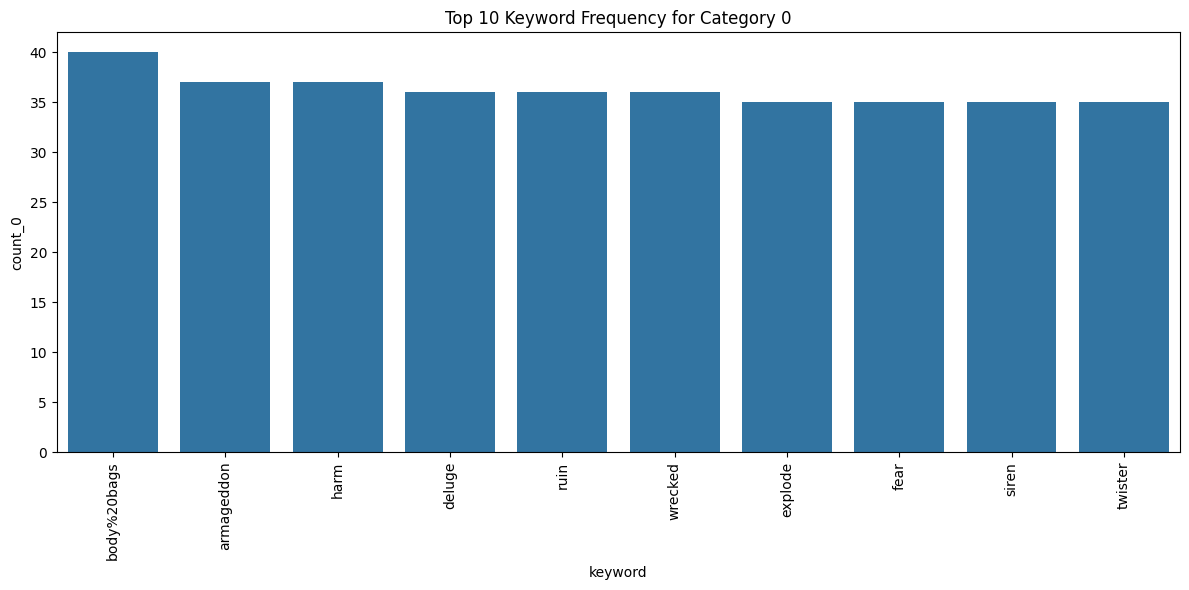

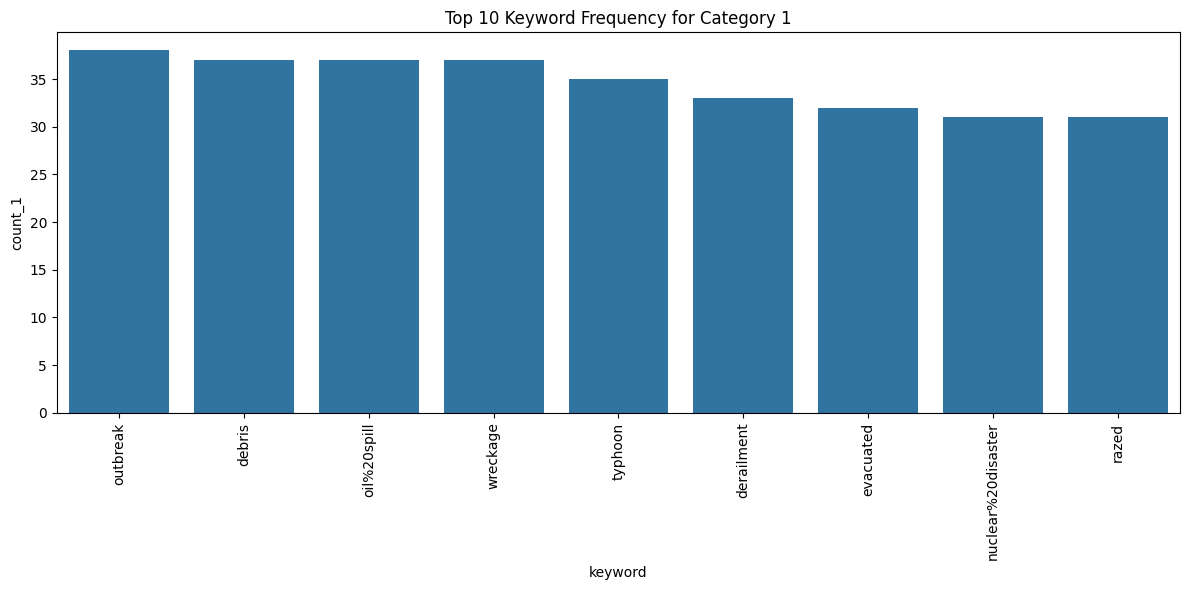

In [83]:
# Let's make a histogram of the keywords for disaster tweets vs non-disaster. 
keywords_category_0 = train[train['target'] == 0]['keyword'].explode().tolist()
keywords_category_1 = train[train['target'] == 1]['keyword'].explode().tolist()

# Count the keyword frequencies
counter_0 = Counter(keywords_category_0)
counter_1 = Counter(keywords_category_1)

# Convert Counter objects to DataFrame
df_counter_0 = pd.DataFrame(counter_0.items(), columns=['keyword', 'count_0'])
df_counter_1 = pd.DataFrame(counter_1.items(), columns=['keyword', 'count_1'])

# Get top 10 keywords for category 0
df_counter_0_top10 = df_counter_0.nlargest(10, 'count_0')

# Get top 10 keywords for category 1
df_counter_1_top10 = df_counter_1.nlargest(10, 'count_1')

# Plot top 10 keywords for category 0
plt.figure(figsize=(12, 6))
sns.barplot(x='keyword', y='count_0', data=df_counter_0_top10)
plt.title('Top 10 Keyword Frequency for Category 0')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot top 10 keywords for category 1
plt.figure(figsize=(12, 6))
sns.barplot(x='keyword', y='count_1', data=df_counter_1_top10)
plt.title('Top 10 Keyword Frequency for Category 1')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The words are subtly different. Let's look at word clouds for the tweets themselves.

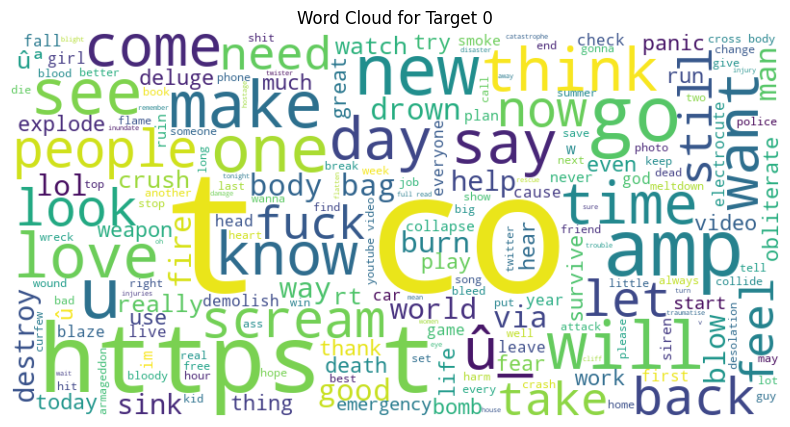

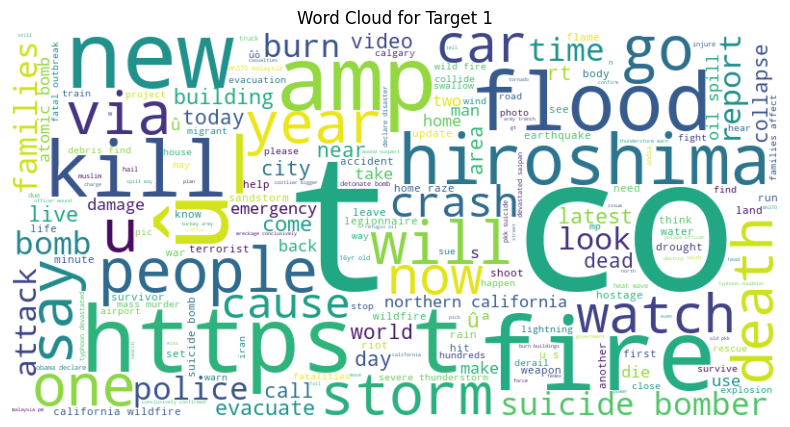

In [84]:
# Separate the tweets by target category
tweets_target_0 = train[train['target'] == 0]['text'].tolist()
tweets_target_1 = train[train['target'] == 1]['text'].tolist()

# Join all tweets for each category into a single string
text_target_0 = ' '.join(tweets_target_0)
text_target_1 = ' '.join(tweets_target_1)

# Generate the word clouds
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_target_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_target_1)

# Plot word cloud for target 0
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Target 0')
plt.show()

# Plot word cloud for target 1
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Target 1')
plt.show()

Looks like the data could still be cleaned up a bit more. But it's promising that there are different words appearing in each. Fire really stands out in the actual disaster tweets, but it's also present in the nondisaster tweets. I think word sequencing will be really important for getting anything out of the tweets.

## Model Architecture
We're going to try a LSTM. LSTMs can learn to identify patterns across words in a tweet, capturing not just the immediate preceding word but the broader context. It can also handle different input lengths, which will be good for tweets of different length. The meaning of a word in a tweet really depends on the context established by the previous words, which LSTMs can retain.

I still need to process the text to matrix form. I'm going to train a Word2Vec model on the tweets to convert them to vectors. Word2Vec uses a predictive model to learn word vectors. You can train embeddings on your specific dataset, which might help if the tweets have slang. It's good a local context.

In [85]:
# Function to clean and tokenize text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    tokens = word_tokenize(text)  # Tokenize the text
    return tokens

# Apply preprocessing to the 'tweets' column
train['tokenized_tweet'] = train['text'].apply(preprocess_text)
test['tokenized_tweet'] = test['text'].apply(preprocess_text)

# Create the Word2Vec model
# Size: dimension of the word vectors
# Window: context window size
# Min_count: minimum frequency of words to include
word2vec_model = Word2Vec(sentences=train['tokenized_tweet'], vector_size=100, window=5, min_count=1)

# Save the word vectors in a dictionary for easy lookup
word_vectors = word2vec_model.wv

Now I'll convert each tweet into a vector by averaging the word vectors for the words in the tweet.

In [104]:
# Function to get the Word2Vec vector for a word
def get_word_vector(word, word_vectors, embedding_dim):
    if word in word_vectors:
        return word_vectors[word]
    else:
        return np.zeros(embedding_dim)

# Function to convert a tweet to a Word2Vec vector (by averaging word vectors)
def tweet_to_word2vec_vector(tokens, word_vectors, embedding_dim=100):
    word_vectors_in_tweet = [get_word_vector(word, word_vectors, embedding_dim) for word in tokens]
    if len(word_vectors_in_tweet) > 0:
        return np.mean(word_vectors_in_tweet, axis=0)  # Average the word vectors
    else:
        return np.zeros(embedding_dim)  # Return a zero vector if no valid words

# Apply the function to each tweet in the dataframe
embedding_dim = 100 
train['tweet_vector'] = train['tokenized_tweet'].apply(lambda tokens: tweet_to_word2vec_vector(tokens, word_vectors, embedding_dim))
test['tweet_vector'] = test['tokenized_tweet'].apply(lambda tokens: tweet_to_word2vec_vector(tokens, word_vectors, embedding_dim))
# convert to matrix
train_matrix = np.stack(train['tweet_vector'].values)
test_matrix = np.stack(test['tweet_vector'].values)

Now we need to convert the matrix and targets into a format PyTorch can handle.

In [107]:
# Convert tweet matrix and labels to PyTorch tensors
train_matrix_tensor = torch.tensor(train_matrix, dtype=torch.float32)
train_labels_tensor = torch.tensor(train['target'].values, dtype=torch.long)
test_matrix_tensor = torch.tensor(test_matrix, dtype=torch.float32)

# Custom dataset class to handle tweets and labels
class TweetDataset(Dataset):
    def __init__(self, tweets, labels=None):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.tweets[idx], self.labels[idx]  # Return tweet and label if available
        return self.tweets[idx]  # Return only tweet if labels are not available

# Create the dataset and dataloader
train_dataset = TweetDataset(train_matrix_tensor, train_labels_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Custom dataset class without labels for test data
class TweetDataset(Dataset):
    def __init__(self, tweets):
        self.tweets = tweets

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return self.tweets[idx]  # Only return the tweet

# Create test dataset
test_dataset = TweetDataset(test_matrix)

# Create DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [108]:
class TweetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(TweetLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer (from hidden state output of LSTM)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Use the output from the last time step
        out = out[:, -1, :]  # Take the last time step's output
        
        # Pass the output through the fully connected layer
        out = self.fc(out)
        return out

# Parameters for the LSTM model
input_size = train_matrix.shape[1]  # This should be the embedding dimension (e.g., 100)
hidden_size = 128  # Number of hidden units
num_layers = 2  # Number of LSTM layers
output_size = 2  # Output size (binary classification: 0 or 1)

# Instantiate the model
model = TweetLSTM(input_size, hidden_size, num_layers, output_size)

Now we can try training the model.

In [109]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Initialize lists to keep track of losses
train_losses = []

# Training loop
num_epochs = 10 
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    total_steps = len(train_dataloader)
    
    for step, (tweets, labels) in enumerate(train_dataloader):
        # Move data to the correct device (GPU or CPU)
        tweets, labels = tweets.to(torch.device("cpu")), labels.to(torch.device("cpu"))

        # Forward pass
        outputs = model(tweets.unsqueeze(1))  # Adding extra dimension for LSTM
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Print loss every 100 steps
        if (step + 1) % 100 == 0:
            avg_loss = running_loss / (step + 1)  # Calculate average loss up to this step
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{step + 1}/{total_steps}], Average Loss: {avg_loss:.4f}')

    # Average loss for the epoch (optional)
    epoch_loss = running_loss / len(train_dataloader)
    train_losses.append(epoch_loss)  # Store the average loss for this epoch

Epoch [1/10], Step [100/118], Average Loss: 0.6806
Epoch [2/10], Step [100/118], Average Loss: 0.6796
Epoch [3/10], Step [100/118], Average Loss: 0.6752
Epoch [4/10], Step [100/118], Average Loss: 0.6736
Epoch [5/10], Step [100/118], Average Loss: 0.6586
Epoch [6/10], Step [100/118], Average Loss: 0.6211
Epoch [7/10], Step [100/118], Average Loss: 0.6139
Epoch [8/10], Step [100/118], Average Loss: 0.6016
Epoch [9/10], Step [100/118], Average Loss: 0.5965
Epoch [10/10], Step [100/118], Average Loss: 0.5981


## Results and Analysis
I'm going to plot these losses and do some hyperparameter tuning/try different architectures.

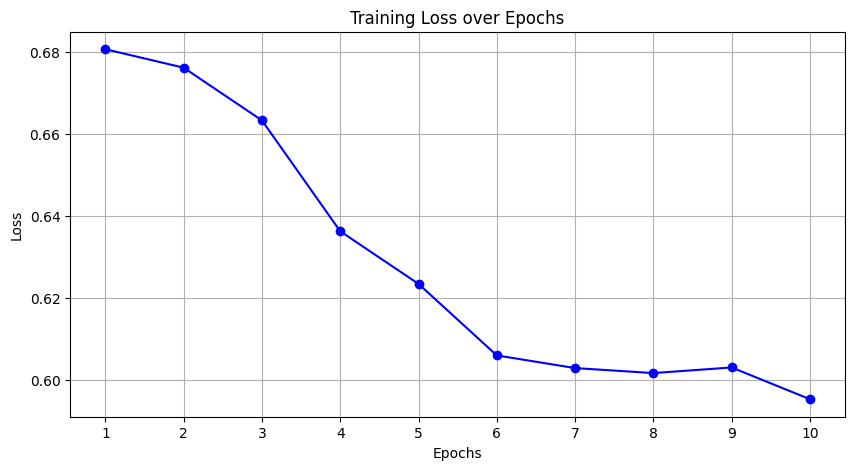

In [91]:
# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))  # Set x-ticks to be each epoch
plt.grid()
plt.show()

Unfortunately the test dataset does not have targets in it, so I can't view the accuracy. At a minimum I think I could adjust the learning rate. I'm also going to try adding more layers.

In [126]:
# Parameters for the LSTM model
input_size = train_matrix.shape[1]  # This should be the embedding dimension (e.g., 100)
hidden_size = 128  # Number of hidden units
num_layers = 4  # Number of LSTM layers
output_size = 2  # Output size (binary classification: 0 or 1)

# Instantiate the model
model2 = TweetLSTM(input_size, hidden_size, num_layers, output_size)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.005)  # Adam optimizer

# Initialize lists to keep track of losses
train_losses = []

# Training loop
num_epochs = 50 
model2.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    total_steps = len(train_dataloader)
    
    for step, (tweets, labels) in enumerate(train_dataloader):
        # Move data to the correct device (GPU or CPU)
        tweets, labels = tweets.to(torch.device("cpu")), labels.to(torch.device("cpu"))

        # Forward pass
        outputs = model2(tweets.unsqueeze(1))  # Adding extra dimension for LSTM
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Print loss every 100 steps
        if (step + 1) % 100 == 0:
            avg_loss = running_loss / (step + 1)  # Calculate average loss up to this step
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{step + 1}/{total_steps}], Average Loss: {avg_loss:.4f}')

    # Average loss for the epoch (optional)
    epoch_loss = running_loss / len(train_dataloader)
    train_losses.append(epoch_loss)  # Store the average loss for this epoch

Epoch [1/50], Step [100/118], Average Loss: 0.6934
Epoch [2/50], Step [100/118], Average Loss: 0.6934
Epoch [3/50], Step [100/118], Average Loss: 0.6934
Epoch [4/50], Step [100/118], Average Loss: 0.6934
Epoch [5/50], Step [100/118], Average Loss: 0.6934
Epoch [6/50], Step [100/118], Average Loss: 0.6934
Epoch [7/50], Step [100/118], Average Loss: 0.6934
Epoch [8/50], Step [100/118], Average Loss: 0.6934
Epoch [9/50], Step [100/118], Average Loss: 0.6934
Epoch [10/50], Step [100/118], Average Loss: 0.6934
Epoch [11/50], Step [100/118], Average Loss: 0.6934
Epoch [12/50], Step [100/118], Average Loss: 0.6934
Epoch [13/50], Step [100/118], Average Loss: 0.6934
Epoch [14/50], Step [100/118], Average Loss: 0.6934
Epoch [15/50], Step [100/118], Average Loss: 0.6934
Epoch [16/50], Step [100/118], Average Loss: 0.6934
Epoch [17/50], Step [100/118], Average Loss: 0.6934
Epoch [18/50], Step [100/118], Average Loss: 0.6934
Epoch [19/50], Step [100/118], Average Loss: 0.6934
Epoch [20/50], Step [

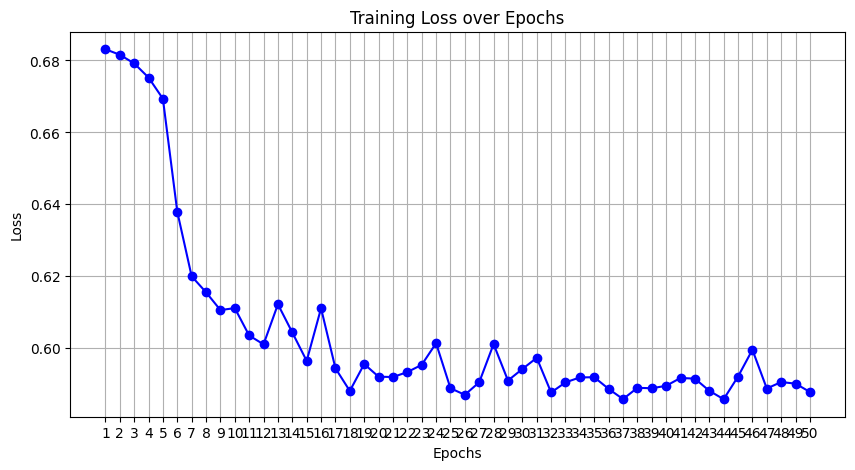

In [125]:
# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))  # Set x-ticks to be each epoch
plt.grid()
plt.show()

Hmm I definitely need some context from a validation set of data. I'm guessing it's probably starting to overfit around the 0.61 loss zone. It seems like adding more layers probably just lead to more over fitting. 

Here's the Kaggle submission stuff. I'm going to use the first model since my attempts at improving it only made it worse.

In [140]:
sample_submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
print(len(sample_submission))

# Switch the model to evaluation mode
model.eval()

# Prepare a list to collect predictions
all_predictions = []

# Disable gradient calculations for inference
with torch.no_grad():
    for tweets in test_dataloader:
        tweets = tweets.to(torch.device("cpu"))  # Move data to the correct device
        tweets = tweets.float()
        outputs = model(tweets.unsqueeze(1))  # Pass the tweets directly to the model

        # Get predicted classes
        _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest score
        all_predictions.extend(predicted.cpu().numpy())  # Store predictions

print(len(all_predictions))
# Save to CSV
sample_submission.to_csv("submission.csv", index=False)


3263
3243


I'm realizing right now that the sample submission didn't expect me to remove any of the datapoints. There are more targets than values I have in test. I don't want to redo the whole thing, but the Kaggle accuracy results will probably be wrong because of the missmatched indices. It would have been nice for the test set to have targets included. 

In [143]:
# Create a DataFrame for predictions
predictions_df = pd.DataFrame({
    'id': test['id'],  # Assuming 'id' is a column in the test DataFrame
    'target': all_predictions  # Your predictions
})

# Merge the predictions DataFrame with sample_submission on 'id'
sample_submission = sample_submission.merge(predictions_df, on='id', how='left', suffixes=('', '_new'))

# Update the target column with the new predictions
sample_submission['target'] = np.where(
    sample_submission['target_new'].isna(),  # Condition: if target_new is NaN
    sample_submission['target'],             # If True: keep original target
    sample_submission['target_new']          # If False: use target_new
)
# I'm just keeping the duplicate test IDs at 0

# Convert the 'target' column to integers and handle None
sample_submission['target'] = sample_submission['target'].astype(int)

# Drop the temporary column
sample_submission.drop(columns=['target_new'], inplace=True)

print("Updated sample_submission:")
print(sample_submission.head())

# Save to CSV
sample_submission.to_csv("submission.csv", index=False)
print("Length of sample_submission:", len(sample_submission))


Updated sample_submission:
   id  target
0   0       1
1   2       0
2   3       0
3   9       0
4  11       1
Length of sample_submission: 3263


## Conclusion
From the Kaggle submission the precision is 0.67912. It looks like it was unprepared for some of the data cleansing I did. I think the hand labeled dataset also had a few mistakes in it. I could also probably have spent hours and hours working on data validity, with cleaning out random characters and urls. 
I think that data cleansing would probably make the neural net have a much easier time with learning. I could probably also mess around with sequence length and maybe BERT. As it is it's only slightly better than just guessing; I wouldn't use it for any actual work.

## References
https://medium.com/@hkabhi916/understanding-lstm-for-sequence-classification-a-practical-guide-with-pytorch-ac40e84ad3d5

https://machinelearningmastery.com/text-generation-with-lstm-in-pytorch/